In [2]:
import math
import random
import time
import torch
import torch.optim as optim

from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.base_env import ActionTuple

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from models import DQN, DuelingDQN, ReplayMemory, optimize_model

def select_action(state_in):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            action_out = policy_net(state_in).max(1).indices.view(1, 1)
            return action_out
    else:
        return torch.tensor(spec.action_spec.random_action(1).discrete, device=device, dtype=torch.long)


In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.1
EPS_DECAY = 100_000
TAU = 0.005
LR = 1e-4

SAVE_WEIGHTS = True
LOAD_WEIGHTS = False
steps_done = 0
STEPS = 250
DOUBLE = True
DUELING = False
GRAPHICS = False

if torch.cuda.is_available():
    num_episodes = 10_000
else:
    num_episodes = 50


In [4]:

env = UnityEnvironment(file_name="unity_builds/snake", seed=1, side_channels=[], no_graphics=not GRAPHICS)
env.reset()

behaviour_name = list(env.behavior_specs)[0]
spec = env.behavior_specs[behaviour_name]

n_actions = spec.action_spec.discrete_branches[0]
state, _ = env.get_steps(behaviour_name)
state = state.obs[0]
n_observations = spec.observation_specs[0].shape[0]

if DUELING:
    policy_net = DuelingDQN(n_observations, n_actions).to(device)
    target_net = DuelingDQN(n_observations, n_actions).to(device)
else:
    policy_net = DQN(n_observations, n_actions).to(device)
    target_net = DQN(n_observations, n_actions).to(device)

if LOAD_WEIGHTS:
    policy_net.load_state_dict(torch.load('weights/policy_net.pth'))
    print("Loaded weights from file")

target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(1000)
print(f"Initialized DQN with {n_observations} observations and {n_actions} actions")
rewards = []
losses = []
lengths = []

Initalized DQN with 29 observations and 4 actions


In [13]:
timer_start = time.perf_counter()
pbar = tqdm(range(num_episodes))
for i_episode in pbar:
    if i_episode % 100 == 0 and i_episode != 0:
        print(
            f"Episode {i_episode}, avg reward: {np.mean(rewards[-100:]):.2f}, "
            f"epsilon: {EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY):.2f}")
        torch.save(policy_net.state_dict(), 'weights/policy_net.pth')
        print("Checkpoint: Saved weights to file")
    step_rewards = []
    step_losses = []
    episode_length = []

    env.reset()
    decision_steps, terminal_steps = env.get_steps(behaviour_name)
    state = decision_steps.obs[0]
    state = torch.tensor(state, dtype=torch.float32, device=device)
    for t in range(STEPS):
        action = select_action(state)
        action_tuple = ActionTuple()
        action_tuple.add_discrete(action.cpu().numpy())
        env.set_actions(behaviour_name, action_tuple)
        env.step()

        assert action.shape[0] == state.shape[0]

        decision_steps, terminal_steps = env.get_steps(behaviour_name)
        observation = decision_steps.obs[0]
        reward = np.zeros(state.shape[0])
        if len(decision_steps.reward) > 0:
            reward += decision_steps.reward
        if len(terminal_steps.reward) > 0:
            reward += terminal_steps.reward
        done = len(decision_steps) == 0
        terminated = len(terminal_steps) > 0

        assert len(reward) == state.shape[0] == action.shape[0]

        # if t % 50 == 0:
        #     print(f"step: {t}, reward: {reward}, state: {state}, action: {action}")
        reward = torch.tensor(reward, device=device)
        step_rewards.append(reward.item())

        if done or terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device)

        memory.push(state, action, next_state, reward)
        state = next_state
        loss = optimize_model(memory, policy_net, target_net, optimizer, device, double=DOUBLE, BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA)
        if loss is not None:
            step_losses.append(loss)

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if terminated or done:
            episode_length.append(t)
            break
    
    if len(step_losses) == 0:
        step_losses.append(0)
    losses.append(np.mean(step_losses))
    lengths.append(np.mean(episode_length))
    ep_rewards = sum(step_rewards)
    pbar.set_description(f"E {i_episode} done after {t + 1} t, with r: {ep_rewards:.2f} and l: {np.mean(step_losses):.2f}")
    rewards.append(ep_rewards)

env.close()
print(f"Finished training in {(time.perf_counter() - timer_start)/60 :.3} minutes")


E 72 done after 72 t, with r: 10.00 and l: 0.03:   1%|▏         | 73/5000 [00:59<1:19:05,  1.04it/s] 

In [6]:

if SAVE_WEIGHTS:
    torch.save(policy_net.state_dict(), 'weights/policy_net.pth')
    rewards_df = pd.DataFrame(rewards, columns=['reward'])
    rewards_df.to_csv('rewards.csv', index=False)
    losses_df = pd.DataFrame(losses, columns=['loss'])
    losses_df.to_csv('losses.csv', index=False)
    lengths_df = pd.DataFrame(lengths, columns=['length'])
    lengths_df.to_csv('lengths.csv', index=False)
    print("Saved weights and data to file")

Saved weights and data to file


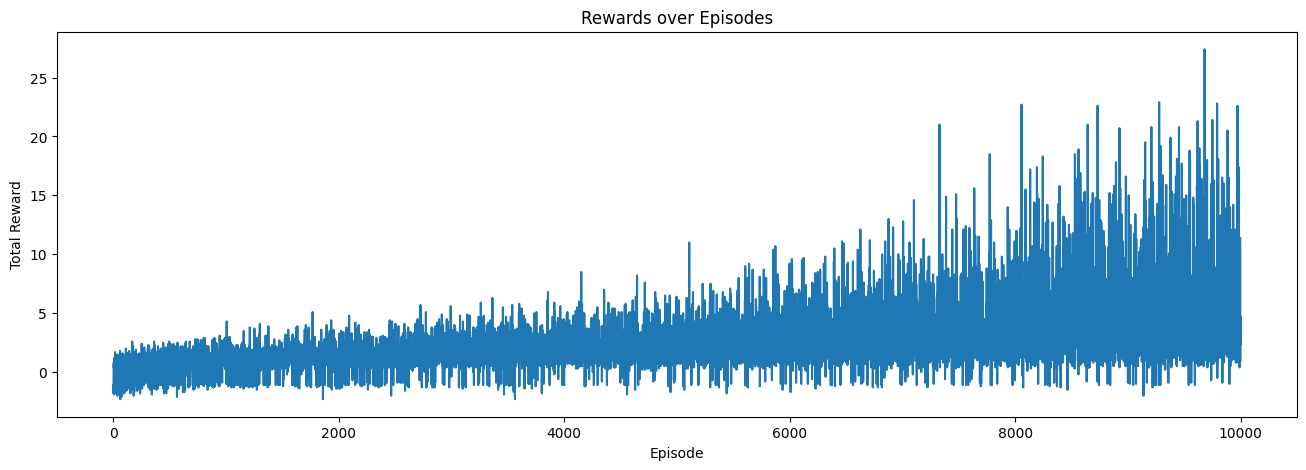

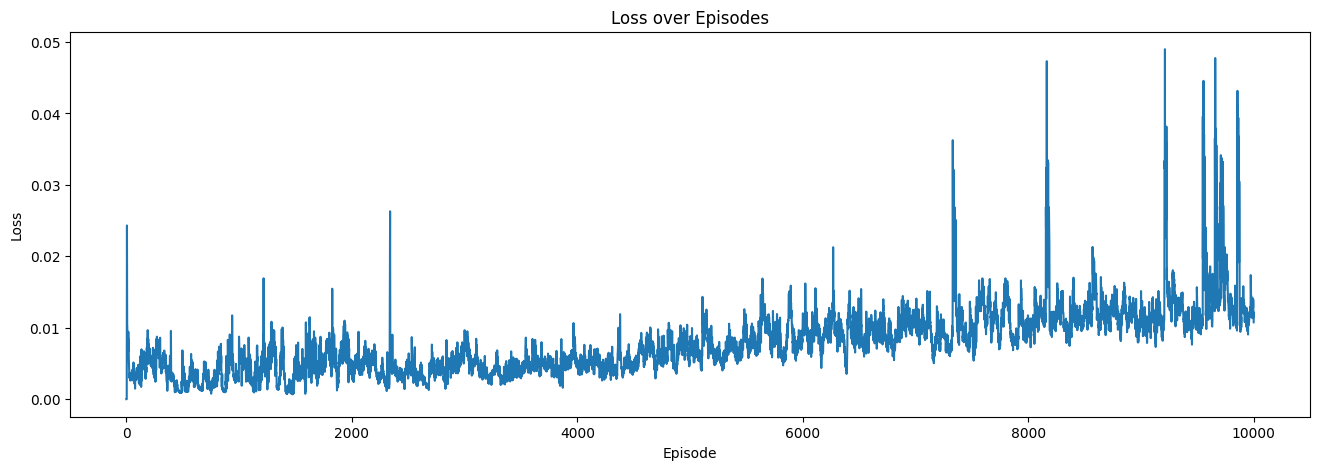

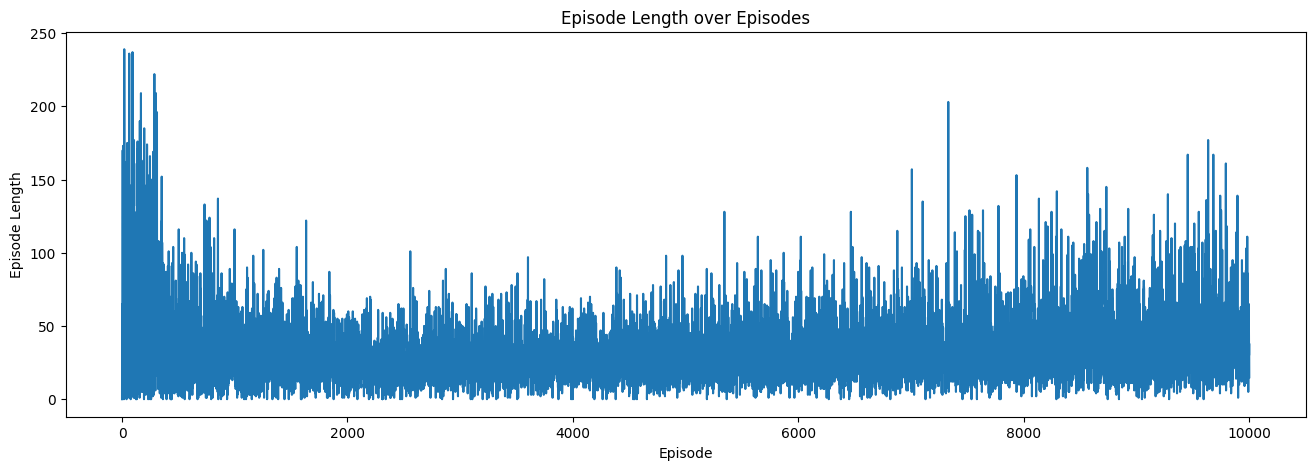

In [7]:

plt.figure(figsize=(16, 5))
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards over Episodes')
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(losses)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Loss over Episodes')
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(lengths)
plt.xlabel('Episode')
plt.ylabel('Episode Length')
plt.title('Episode Length over Episodes')
plt.show()


Inference, see how the trained model performs

In [9]:
env = UnityEnvironment(file_name="unity_builds/snake", seed=0, side_channels=[], no_graphics=False)
env.reset()

behaviour_name = list(env.behavior_specs)[0]
spec = env.behavior_specs[behaviour_name]

n_actions = spec.action_spec.discrete_branches[0]
state, _ = env.get_steps(behaviour_name)
state = state.obs[0]
n_observations = spec.observation_specs[0].shape[0]

for t in range(2):
    env.reset()
    decision_steps, terminal_steps = env.get_steps(behaviour_name)
    state = decision_steps.obs[0]
    state = torch.tensor(state, dtype=torch.float32, device=device)
    while True:
        with torch.no_grad():
            action = policy_net(state).max(1).indices.view(1, 1)
        action_tuple = ActionTuple()
        action_tuple.add_discrete(action.cpu().numpy())
        env.set_actions(behaviour_name, action_tuple)
        env.step()

        decision_steps, terminal_steps = env.get_steps(behaviour_name)
        observation = decision_steps.obs[0]
        # print(observation)
        done = len(decision_steps) == 0
        terminated = len(terminal_steps) > 0

        if done or terminated:
            break
        state = torch.tensor(observation, dtype=torch.float32, device=device)
env.close()